# Regression: predict fuel efficiency

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of comprehensive data exploration using SparkXshards on Orca. 

It is adapted from [TensorFlow tutorial of basic regression] (https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_regression.ipynb) on auto data. 


In [ ]:
# Use seaborn for some plots
!pip install seaborn pandas numpy

In [ ]:
# import necessary libraries
import bigdl.orca.data.pandas
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.data.transformer import *
from bigdl.orca.learn.tf2.estimator import Estimator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Start an OrcaContext and setup backend using "pandas", then it will use pandas to read each file into a pandas dataframe.

In [ ]:
sc = init_orca_context(memory="4g")
OrcaContext.pandas_read_backend = "pandas"

##  Load data in parallel and get general information

Load data into data_shards, it is a SparkXshards that can be operated on in parallel, here each element of the data_shards is a panda dataframe read from a file on the cluster. Users can distribute local code of `pd.read_csv(dataFile)` using `bigdl.orca.data.pandas.read_csv(datapath)`.

In [ ]:
datapath = '../auto-mpg.csv'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
data_shards = bigdl.orca.data.pandas.read_csv(file_path=datapath, names=column_names,
                                              na_values="?", comment='\t',
                                              sep=" ", skipinitialspace=True)


In [5]:
# show the first couple of rows in the data_shards
print(data_shards.head(5))
print(data_shards._get_class_name())

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
# see the num of partitions of data_shards
data_shards.num_partitions()


1

In [7]:
# count total number of rows in the data_shards
len(data_shards)

398

## Clean the data

The dataset contains a few unknown values, drop them

In [8]:
null_cnt_pdf = data_shards.get_null_sum().sort_values(by="total", ascending=False)
null_cnt_pdf.head(5)

,col,total
3,Horsepower,6
0,MPG,0
1,Cylinders,0
2,Displacement,0
4,Weight,0


In [9]:
def drop_na(df):
    df = df.dropna()
    return df
data_shards = data_shards.transform_shard(drop_na)

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [10]:
def generate_extra_cols(df):
    origin = df.pop('Origin')
    df['USA'] = (origin == 1)*1.0
    df['Europe'] = (origin == 2)*1.0
    df['Japan'] = (origin == 3)*1.0
    return df

data_shards = data_shards.transform_shard(generate_extra_cols)

## Inspect the data

Users can compute the descriptive statistics summary of on the full data_shards in a distributed way. For local visualization, users can sample a portion of the data_shards across the cluster into a local panda dataframe, then analyze it using traditional tools like seaborn for plots.

###  Local visualization

Users can call `data_shards.sample_to_pdf(frac)` to sample a portion of the data_shards and bring back to a panda dataframe on local for visualization. 
Just a few examples are shown in here.

In [12]:
# 0 < frac <= 1, here frac = 1.0 is chosen to collect and show full data.
pdf = data_shards.sample_to_pdf(frac = 1.0)

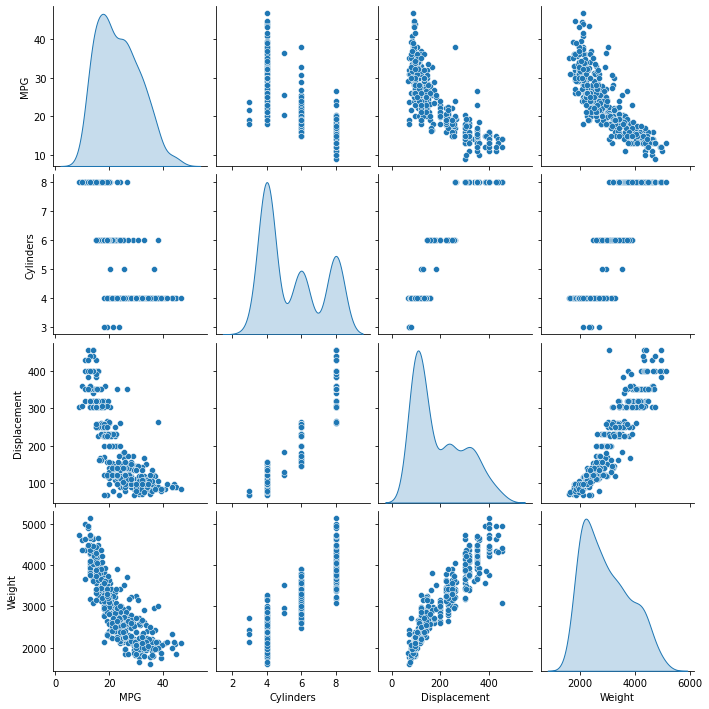

In [13]:
sns.pairplot(pdf[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

Plot scatter plots to show relationship with numerical variables.

## Normalize the data using MinMaxScaler

In [14]:
columns = data_shards.get_schema()['columns']
print(columns)
scaler = MinMaxScaler(inputCol=list(columns[1:]), outputCol="scaled_vec")
data_shards = scaler.fit_transform(data_shards)

['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan']
createDataFrame from shards attempted Arrow optimization failed as: 'NoneType' object has no attribute 'json',Will try without Arrow optimization
create shards from Spark DataFrame attempted Arrow optimization failed as: name 'df' is not defined. Will try without Arrow optimization


## Train validation split

In [15]:
def split_train_test(df):
    train_df = df.sample(frac=0.8, random_state=0)
    test_df = df.drop(train_df.index)
    return train_df, test_df

shards_train, shards_val = data_shards.transform_shard(split_train_test).split()

In [16]:
shards_train.head(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan,081c9e2e-6871-11ed-aba1-dca9048df0d4x_vec,scaled_vec
144,28.0,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0,"[4.0, 90.0, 75.0, 2125.0, 14.5, 74.0, 1.0, 0.0...","[0.20000000298023224, 0.05684754624962807, 0.1..."
280,22.3,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0,"[4.0, 140.0, 88.0, 2890.0, 17.299999237060547,...","[0.20000000298023224, 0.1860465109348297, 0.22..."
68,12.0,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0,"[8.0, 350.0, 160.0, 4456.0, 13.5, 72.0, 1.0, 0...","[1.0, 0.7286821603775024, 0.6195651888847351, ..."
372,38.0,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0,"[4.0, 105.0, 63.0, 2125.0, 14.699999809265137,...","[0.20000000298023224, 0.09560723602771759, 0.0..."
328,33.8,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0,"[4.0, 97.0, 67.0, 2145.0, 18.0, 80.0, 0.0, 0.0...","[0.20000000298023224, 0.07493539899587631, 0.1..."


In [18]:
print(len(shards_train), len(shards_val))

314 78


## The model

Build the model model as usual. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model.


In [19]:
def build_model(config):
    model = Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=[9]),
        Dense(64, activation=tf.nn.relu),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [21]:
est = Estimator.from_keras(model_creator=build_model)

In [ ]:
EPOCHS = 1000
batch_size = 16
train_steps = math.ceil(len(shards_train) / batch_size)
est.fit(data=shards_train,
        batch_size=batch_size,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        feature_cols=['scaled_vec'],
        label_cols=['MPG'])

In [23]:
stop_orca_context()

Stopping orca context
